In [ ]:
#conect to the Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Nalaiya Thiran /Fertilizers_Recommendation_ System_For_Disease_ Prediction.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Dataset Plant Disease/Veg-dataset/Veg-dataset/train_set/Tomato___Bacterial_spot/d8914e04-4e33-4189-bfa9-f547e5f696d1___GCREC_Bact.Sp 3173.JPG  
  inflating: Dataset Plant Disease/Veg-dataset/Veg-dataset/train_set/Tomato___Bacterial_spot/d8a64b79-e21e-4158-9d9d-47bd6e44fba0___GCREC_Bact.Sp 3594.JPG  
  inflating: Dataset Plant Disease/Veg-dataset/Veg-dataset/train_set/Tomato___Bacterial_spot/d8a90b81-eb30-461d-80ba-4fa9c93f379d___GCREC_Bact.Sp 3757.JPG  
  inflating: Dataset Plant Disease/Veg-dataset/Veg-dataset/train_set/Tomato___Bacterial_spot/d8b6f17a-5189-47ae-904f-be4a09dce0ad___UF.GRC_BS_Lab Leaf 9009.JPG  
  inflating: Dataset Plant Disease/Veg-dataset/Veg-dataset/train_set/Tomato___Bacterial_spot/d8d2baf6-87de-43e5-bd40-48dfe33841d3___GCREC_Bact.Sp 5747.JPG  
  inflating: Dataset Plant Disease/Veg-dataset/Veg-dataset/train_set/Tomato___Bacterial_spot/d8d3c759-4242-42c0-9be5-b3177f2664be___GCREC_Bact.Sp 5953.JPG  
  

**START PREPARE AND RUN TRAIN OUR MODEL**

Download modules

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
#from tensorflow.python.keras.optimizers import Adam, RMSprop
#from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy import loadtxt
import tensorflow.keras
from PIL import Image, ImageOps
%matplotlib inline

Set image size & batch size

In [ ]:
from PIL import Image

#read the image
im = Image.open("/content/Dataset Plant Disease/Veg-dataset/Veg-dataset/test_set/Pepper,_bell___healthy/b06117a8-6ca6-4b82-96cf-07604beb8f1b___JR_HL 5906.JPG")

#image size
print(im.size)

(256, 256)


In [24]:
import PIL
import os
import os.path
from PIL import Image

f = r'/content/Dataset Plant Disease/Veg-dataset/Veg-dataset/train_set/Tomato___Septoria_leaf_spot'
for file in os.listdir(f):
    f_img = f+"/"+file
    img = Image.open(f_img)
    img = img.resize((224,224))
    img.save(f_img)
print("image are Resized")

image are Resized


In [26]:
from PIL import Image

#read the image
im = Image.open("/content/Dataset Plant Disease/Veg-dataset/Veg-dataset/test_set/Pepper,_bell___healthy/b06117a8-6ca6-4b82-96cf-07604beb8f1b___JR_HL 5906.JPG")

#image size
print(im.size)

(224, 224)


In [25]:
image_size = 224
batch_size = 32

# Create image generator

In [27]:
# folders with train dir & val dir
train_dir = '/content/Dataset Plant Disease/Veg-dataset/Veg-dataset/train_set'
test_dir = '/content/Dataset Plant Disease/Veg-dataset/Veg-dataset/test_set'
testing_dir = '/content/Dataset Plant Disease/Veg-dataset/Veg-dataset/test_set'
input_shape = (image_size, image_size, 3)

Create image data generator for train data

In [28]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1. / 255,
                              height_shift_range= 0.02, 
                              width_shift_range=0.02, 
                              rotation_range=0.02, 
                              shear_range = 0.01,
                              fill_mode='nearest',
                              zoom_range=0.01)

Check generator

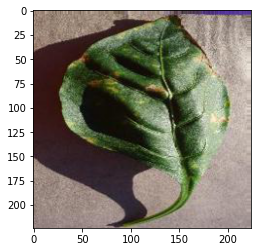

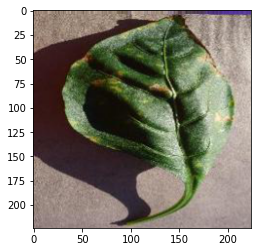

In [29]:
img_path = '/content/Dataset Plant Disease/Veg-dataset/Veg-dataset/test_set/Pepper,_bell___Bacterial_spot/adbfa5e7-23a5-4df0-9cae-1e54115619cb___NREC_B.Spot 1786.JPG'
img = image.load_img(img_path, target_size=(image_size, image_size))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 2 == 0:
        break
plt.show()

Setting train generator

In [30]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 11386 images belonging to 9 classes.


Setting test generator without data augmentation

In [31]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 3416 images belonging to 9 classes.


Setting tesing generator without data augmentation

In [32]:
testing_datagen = ImageDataGenerator(rescale=1. / 255)

testing_generator = testing_datagen.flow_from_directory(
    testing_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')

Found 3416 images belonging to 9 classes.


Print count classes

In [33]:
train_generator.class_indices

{'Pepper,_bell___Bacterial_spot': 0,
 'Pepper,_bell___healthy': 1,
 'Potato___Early_blight': 2,
 'Potato___Late_blight': 3,
 'Potato___healthy': 4,
 'Tomato___Bacterial_spot': 5,
 'Tomato___Late_blight': 6,
 'Tomato___Leaf_Mold': 7,
 'Tomato___Septoria_leaf_spot': 8}

Graph count images per classes "train"



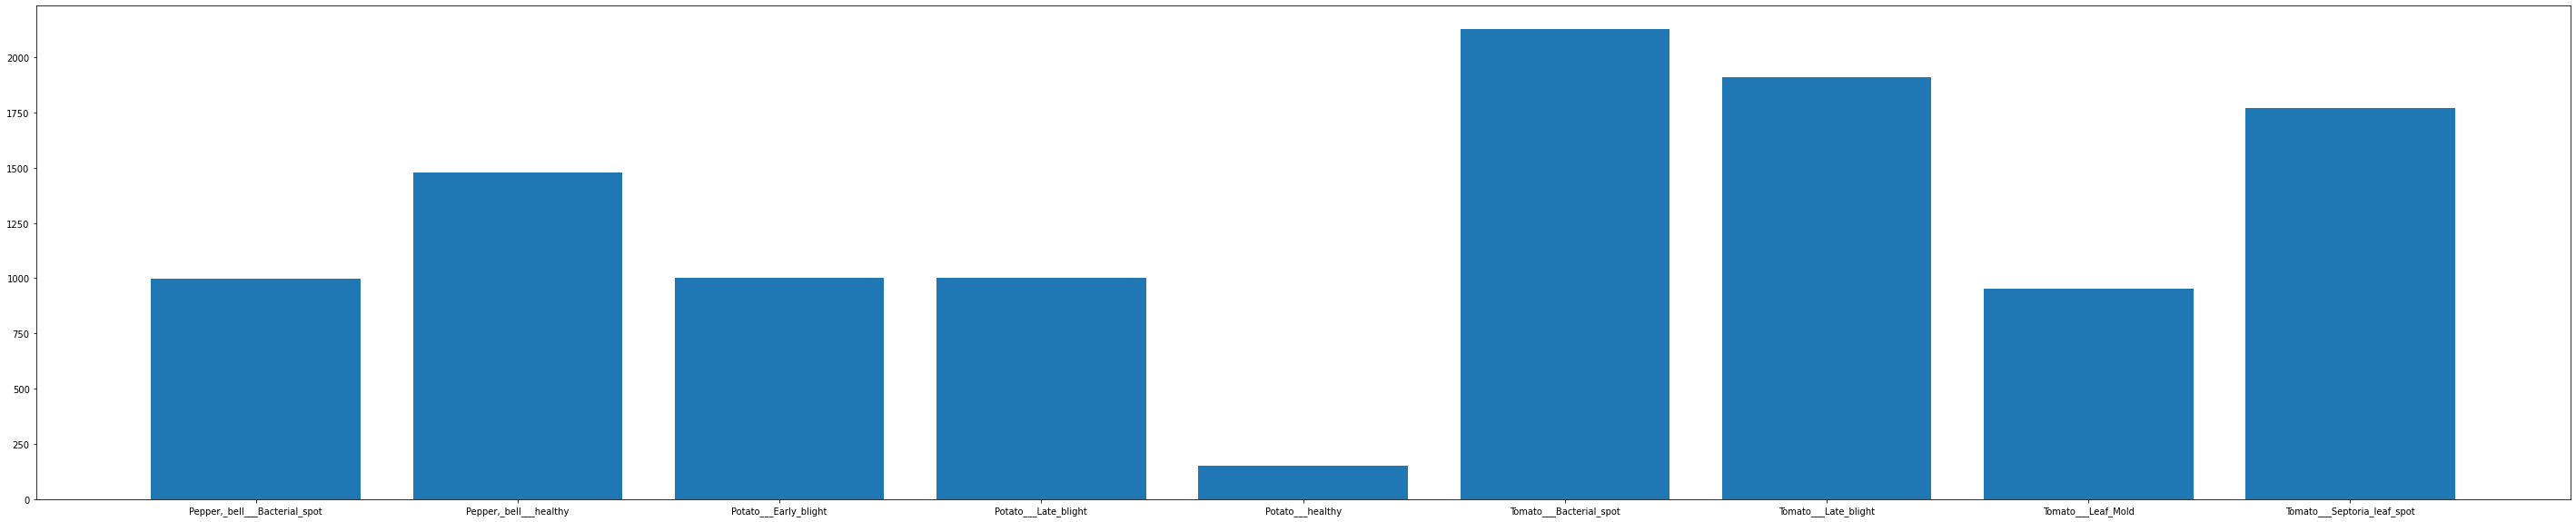

In [34]:
from sklearn.utils.class_weight import compute_class_weight
cls_train = train_generator.classes
from collections import OrderedDict
classes = list(train_generator.class_indices.keys())
num_values = []
unique, counts = np.unique(cls_train, return_counts=True)
valdict=OrderedDict(zip(unique, counts))
for i in range(9):
    num_values.append(valdict[i])
plt.figure(figsize=(50,10))
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)
plt.show()   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


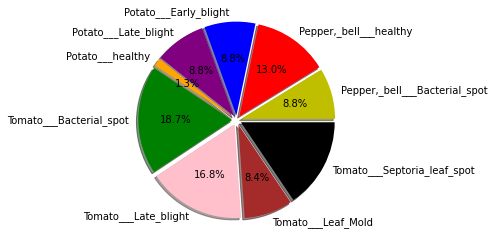

In [35]:
import matplotlib.pyplot as plt
goal_types = list(train_generator.class_indices.keys())
unique, counts = np.unique(cls_train, return_counts=True)
goals = [(counts)]
colors = ['y','r','blue','purple','orange','Green','Pink','Brown','black']
plt.pie(goals, labels = goal_types, colors=colors ,shadow = True, explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05), autopct = '%1.1f%%')
plt.axis('equal')
plt.show()

Graph count images per classes "test"

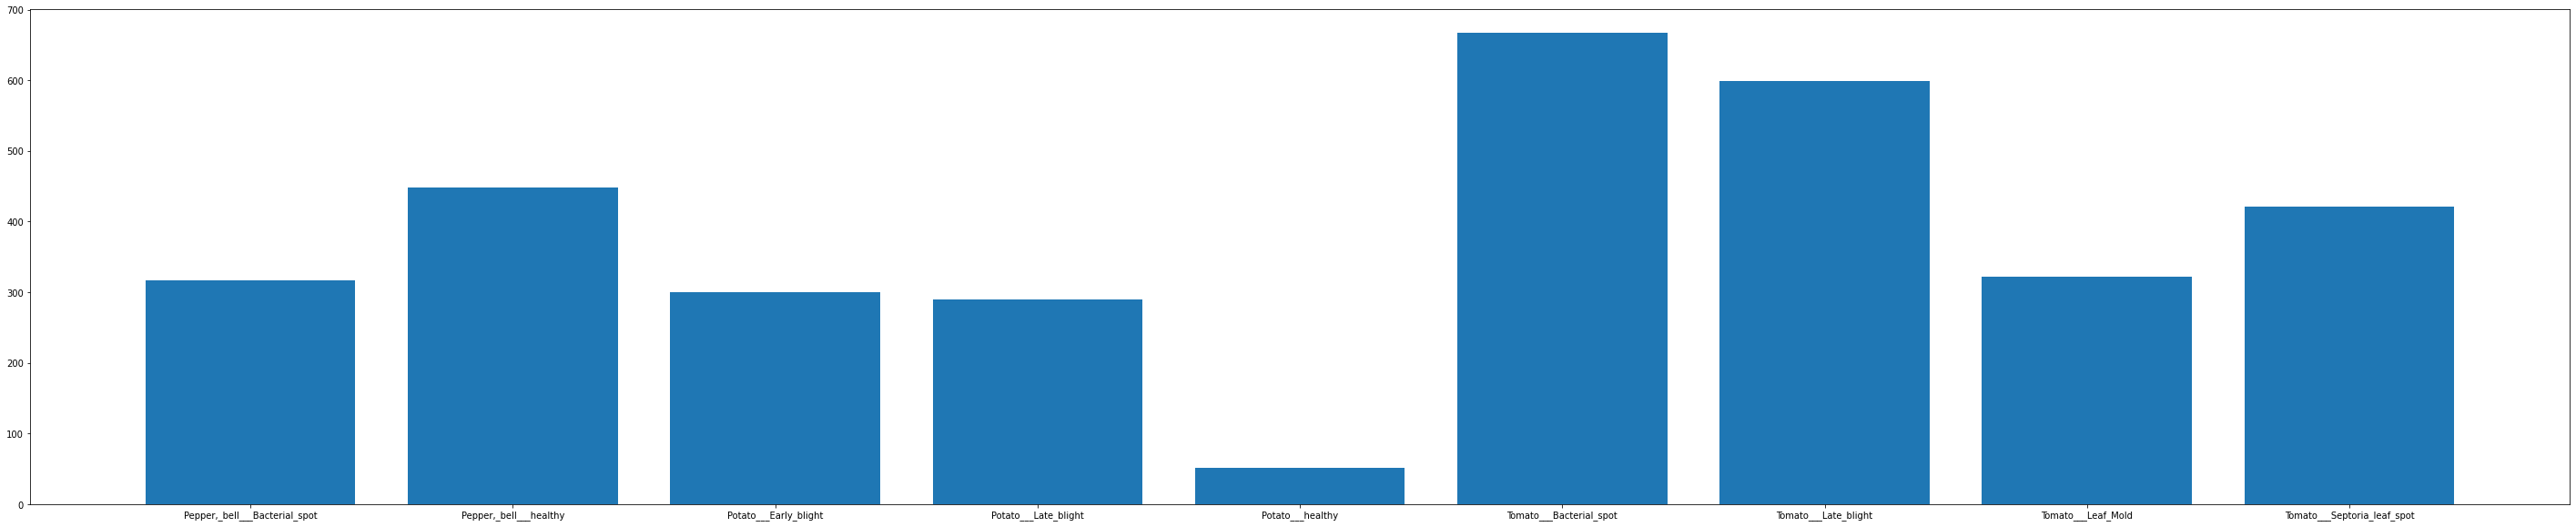

In [36]:
from sklearn.utils.class_weight import compute_class_weight
cls_test = test_generator.classes
from collections import OrderedDict


classes = list(test_generator.class_indices.keys())
num_values = []
unique, counts = np.unique(cls_test, return_counts=True)
valdict=OrderedDict(zip(unique, counts))
for i in range(9):
    num_values.append(valdict[i])
plt.figure(figsize=(50,10))
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)
plt.show() 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  import sys


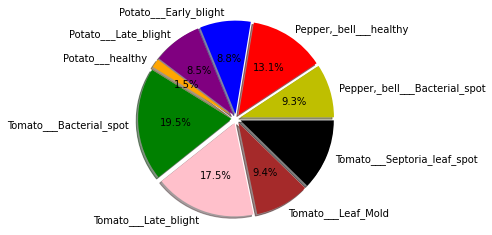

In [37]:
import matplotlib.pyplot as plt

goal_types = list(test_generator.class_indices.keys())
unique, counts = np.unique(cls_test, return_counts=True)
goals = [(counts)]
colors = ['y','r','blue','purple','orange','Green','Pink','Brown','black']
plt.pie(goals, labels = goal_types, colors=colors ,shadow = True, explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05), autopct = '%1.1f%%')
plt.axis('equal')

plt.show()